In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('/content/drive/MyDrive/dataset/fake_data_20220801.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['local', 'temp', 'humidity', 'metter']
dataset.index.name = 'date'
# mark all NA values with 0
# dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
# dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5)) 
# save to file
dataset.to_csv('/content/drive/MyDrive/dataset/pollution.csv')

                     local  temp  humidity  metter
date                                              
2022-08-01 09:00:00      1  23.5      38.3       3
2022-08-01 09:00:00      2  23.6      37.0       3
2022-08-01 09:00:00      3  23.8      35.0       3
2022-08-01 09:00:00      4  23.9      34.0       3
2022-08-01 09:00:00      5  23.3      33.5       2


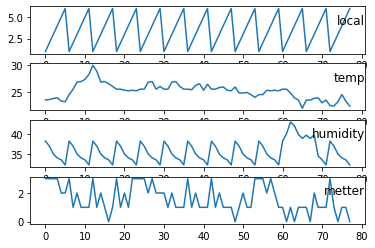

In [3]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('/content/drive/MyDrive/dataset/pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [12]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	# print(df)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('/content/drive/MyDrive/dataset/pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[]], axis=1, inplace=True)
print(reframed.head())

      0         1         2         3
0   0.0  0.189873  0.554545  1.000000
1   0.2  0.202532  0.436364  1.000000
2   0.4  0.227848  0.254545  1.000000
3   0.6  0.240506  0.163636  1.000000
4   0.8  0.164557  0.118182  0.666667
..  ...       ...       ...       ...
73  0.2  0.050633  0.436364  0.333333
74  0.4  0.151899  0.254545  0.000000
75  0.6  0.316456  0.163636  0.333333
76  0.8  0.164557  0.118182  0.333333
77  1.0  0.050633  0.000000  0.000000

[78 rows x 4 columns]
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var1(t)   var2(t)   var3(t)  \
1        0.0   0.189873   0.554545   1.000000      0.2  0.202532  0.436364   
2        0.2   0.202532   0.436364   1.000000      0.4  0.227848  0.254545   
3        0.4   0.227848   0.254545   1.000000      0.6  0.240506  0.163636   
4        0.6   0.240506   0.163636   1.000000      0.8  0.164557  0.118182   
5        0.8   0.164557   0.118182   0.666667      1.0  0.151899  0.000000   

    var4(t)  
1  1.000000  
2  1.000000  
3  1.00000

In [9]:

# split into train and test sets
values = reframed.values
n_train_hours = 6*6
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(36, 1, 5) (36,) (41, 1, 5) (41,)


Epoch 1/50
1/1 - 2s - loss: 0.7019 - val_loss: 0.4749 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.6924 - val_loss: 0.4664 - 28ms/epoch - 28ms/step
Epoch 3/50
1/1 - 0s - loss: 0.6829 - val_loss: 0.4579 - 23ms/epoch - 23ms/step
Epoch 4/50
1/1 - 0s - loss: 0.6734 - val_loss: 0.4493 - 22ms/epoch - 22ms/step
Epoch 5/50
1/1 - 0s - loss: 0.6639 - val_loss: 0.4412 - 23ms/epoch - 23ms/step
Epoch 6/50
1/1 - 0s - loss: 0.6546 - val_loss: 0.4338 - 22ms/epoch - 22ms/step
Epoch 7/50
1/1 - 0s - loss: 0.6456 - val_loss: 0.4275 - 23ms/epoch - 23ms/step
Epoch 8/50
1/1 - 0s - loss: 0.6367 - val_loss: 0.4215 - 28ms/epoch - 28ms/step
Epoch 9/50
1/1 - 0s - loss: 0.6278 - val_loss: 0.4156 - 23ms/epoch - 23ms/step
Epoch 10/50
1/1 - 0s - loss: 0.6189 - val_loss: 0.4097 - 21ms/epoch - 21ms/step
Epoch 11/50
1/1 - 0s - loss: 0.6100 - val_loss: 0.4038 - 27ms/epoch - 27ms/step
Epoch 12/50
1/1 - 0s - loss: 0.6011 - val_loss: 0.3978 - 32ms/epoch - 32ms/step
Epoch 13/50
1/1 - 0s - loss: 0.5922 - val_loss: 0.391

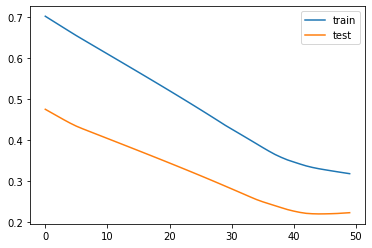

In [10]:

from keras.models import Sequential
from keras.layers import Dense, LSTM 
from keras.layers import BatchNormalization

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False,)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [11]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.addconcatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: ignored